## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statstests.process import stepwise
from utils.data_wrangling import normalize_string, pascal_to_snake, get_formula
from utils.modeling_metrics import vif_tolerance, confusion_matrix, confusion_metrics
from sklearn.metrics import auc, roc_curve

## Load Files

In [2]:
df_telco = pd.read_csv("churn_dataset.csv")

## Data Wrangling

In [6]:
# Visualizing data
df_telco

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# Inspecting DataFrame structure
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Standardizing column names for easier data manipulation
df_telco.rename({
    "customerID": "customer_id",
    "StreamingTV": "streaming_tv"
    },
axis=1,
inplace=True
)

df_telco.columns = pascal_to_snake(df_telco.columns)

df_telco.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [6]:
# Fixing `total_charges` data type
df_telco["total_charges"] = pd.to_numeric(df_telco.total_charges, errors='coerce')

In [7]:
# Checking for missing values (NA) in rows
na_rows = df_telco.isna().any(axis=1).sum()
print(F"Number of rows with missing values: {na_rows}")

Number of rows with missing values: 11


In [8]:
# Dropping rows with missing values
df_telco.dropna(how="any", inplace=True)
na_rows = df_telco.isna().any(axis=1).sum()
print(F"Number of rows with missing values: {na_rows}")

Number of rows with missing values: 0


In [9]:
# Checking for duplicated rows
duplicated_rows = df_telco.duplicated().sum()
print(F"Number of duplicated rows: {duplicated_rows}")

Number of duplicated rows: 0


In [10]:
# Descriptive statistics for numeric variables
df_telco.describe()

,senior_citizen,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [11]:
# Summary of non-numeric variables
df_telco.select_dtypes(include=object).describe().T

,count,unique,top,freq
customer_id,7032,7032,3186-AJIEK,1
gender,7032,2,Male,3549
partner,7032,2,No,3639
dependents,7032,2,No,4933
phone_service,7032,2,Yes,6352
multiple_lines,7032,3,No,3385
internet_service,7032,3,Fiber optic,3096
online_security,7032,3,No,3497
online_backup,7032,3,No,3087
device_protection,7032,3,No,3094


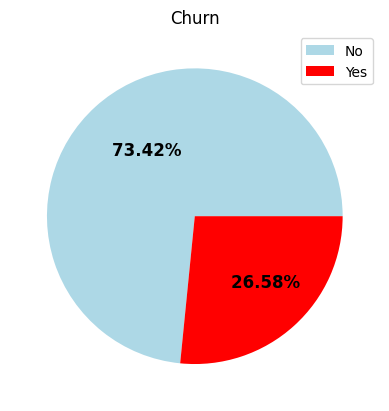

In [12]:
# Churn rate visualization
df_churn = df_telco.churn.value_counts()

plt.pie(
    df_churn,
    autopct="%9.2f%%",
    textprops={"fontsize":12, "weight":"bold"},
    colors={"lightblue":"No", "red":"Yes"},
)

plt.legend(df_churn.index)
plt.title("Churn")
plt.show()

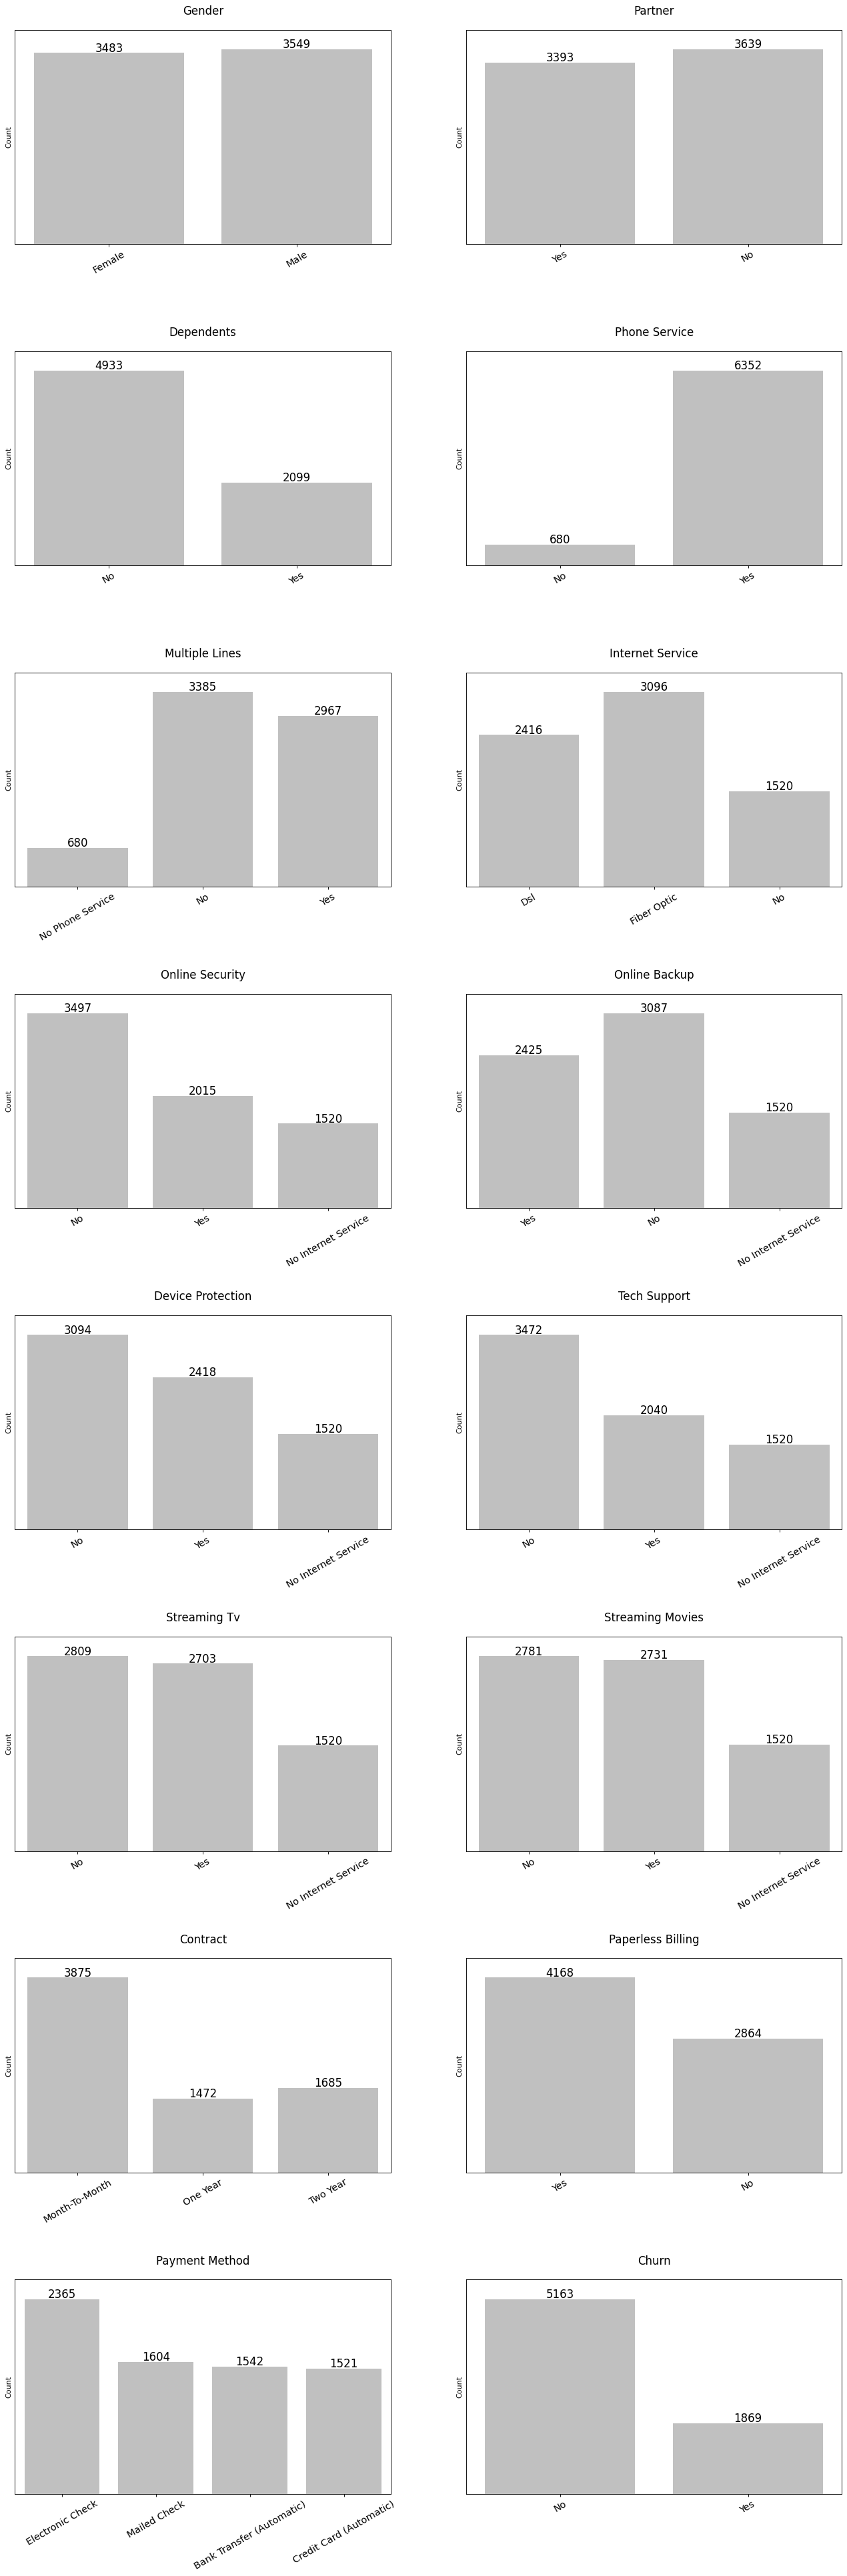

In [13]:
# Overview of categorical variables
df_cat = df_telco.drop("customer_id", axis=1).select_dtypes(object)

fig = plt.figure(figsize=(20, 60), dpi=80)

gs = fig.add_gridspec(np.ceil(df_cat.shape[1]/2).astype(int), 2)

for i, var in enumerate(df_cat.columns):

    x, y = i // 2 , i % 2

    ax = sns.countplot(
        data = df_cat,
        x = var,
        color= "silver",
        ax = fig.add_subplot(gs[x, y])
    )

    ax.bar_label(ax.containers[0], fontsize=15, padding=-2)
    ax.set_ylim([0, max([container.get_height() for container in ax.containers[0]])*1.1])

    plt.xticks(
        ticks = ax.get_xticks(),
        labels = [label.get_text().title() for label in ax.get_xticklabels()],
        rotation = 30,
        fontsize = 13
    )
    plt.yticks([])

    plt.xlabel(None)
    plt.ylabel("Count", fontsize=10)

    plt.title(var.replace("_", " ").title(), fontsize=15, y=1.05)

plt.subplots_adjust(hspace=0.5)
plt.show()

In [15]:
# One-hot encoding
df_telco_dummies = pd.get_dummies(
    data=df_telco,
    columns = df_telco.drop(["churn", "customer_id"], axis=1).select_dtypes(include=object).columns,
    drop_first=True,
    dtype=int
)

df_telco_dummies["churn"] = np.where(df_telco_dummies.churn == 'Yes', 1, 0)

df_telco_dummies.columns = normalize_string(df_telco_dummies.columns)

In [16]:
# Visualizing data with dummies
df_telco_dummies

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,phone_service_yes,...,streaming_tv_no_internet_service,streaming_tv_yes,streaming_movies_no_internet_service,streaming_movies_yes,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_credit_card_automatic,payment_method_electronic_check,payment_method_mailed_check
0,7590-VHVEG,0,1,29.85,29.85,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,24,84.80,1990.50,0,1,1,1,1,...,0,1,0,1,1,0,1,0,0,1
7039,2234-XADUH,0,72,103.20,7362.90,0,0,1,1,1,...,0,1,0,1,1,0,1,1,0,0
7040,4801-JZAZL,0,11,29.60,346.45,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
7041,8361-LTMKD,1,4,74.40,306.60,1,1,1,0,1,...,0,0,0,0,0,0,1,0,0,1


In [17]:
# DataFrame structure after dummies
df_telco_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7032 non-null   object 
 1   senior_citizen                         7032 non-null   int64  
 2   tenure                                 7032 non-null   int64  
 3   monthly_charges                        7032 non-null   float64
 4   total_charges                          7032 non-null   float64
 5   churn                                  7032 non-null   int64  
 6   gender_male                            7032 non-null   int64  
 7   partner_yes                            7032 non-null   int64  
 8   dependents_yes                         7032 non-null   int64  
 9   phone_service_yes                      7032 non-null   int64  
 10  multiple_lines_no_phone_service        7032 non-null   int64  
 11  multiple_

## Multicollinearity diagnosis

Multicollinearity occurs when a predictor variable exhibits a strong correlation with one or more other predictor variables, leading to redundancy in the model and consequently loss of statistical significance.

In [18]:
# Variable Infaltion Factor (VIF) and Tolerance
df_vif_tolerance = vif_tolerance(df=df_telco_dummies, endog="churn", drop_columns=["customer_id"])
df_vif_tolerance

,variables,vif,tolerance
0,multiple_lines_no_phone_service,inf,0.000000
1,phone_service_yes,inf,0.000000
2,internet_service_no,inf,0.000000
3,online_security_no_internet_service,inf,0.000000
4,device_protection_no_internet_service,inf,0.000000
5,online_backup_no_internet_service,inf,0.000000
6,tech_support_no_internet_service,inf,0.000000
7,streaming_tv_no_internet_service,inf,0.000000
8,streaming_movies_no_internet_service,inf,0.000000
9,monthly_charges,866.089640,0.001155


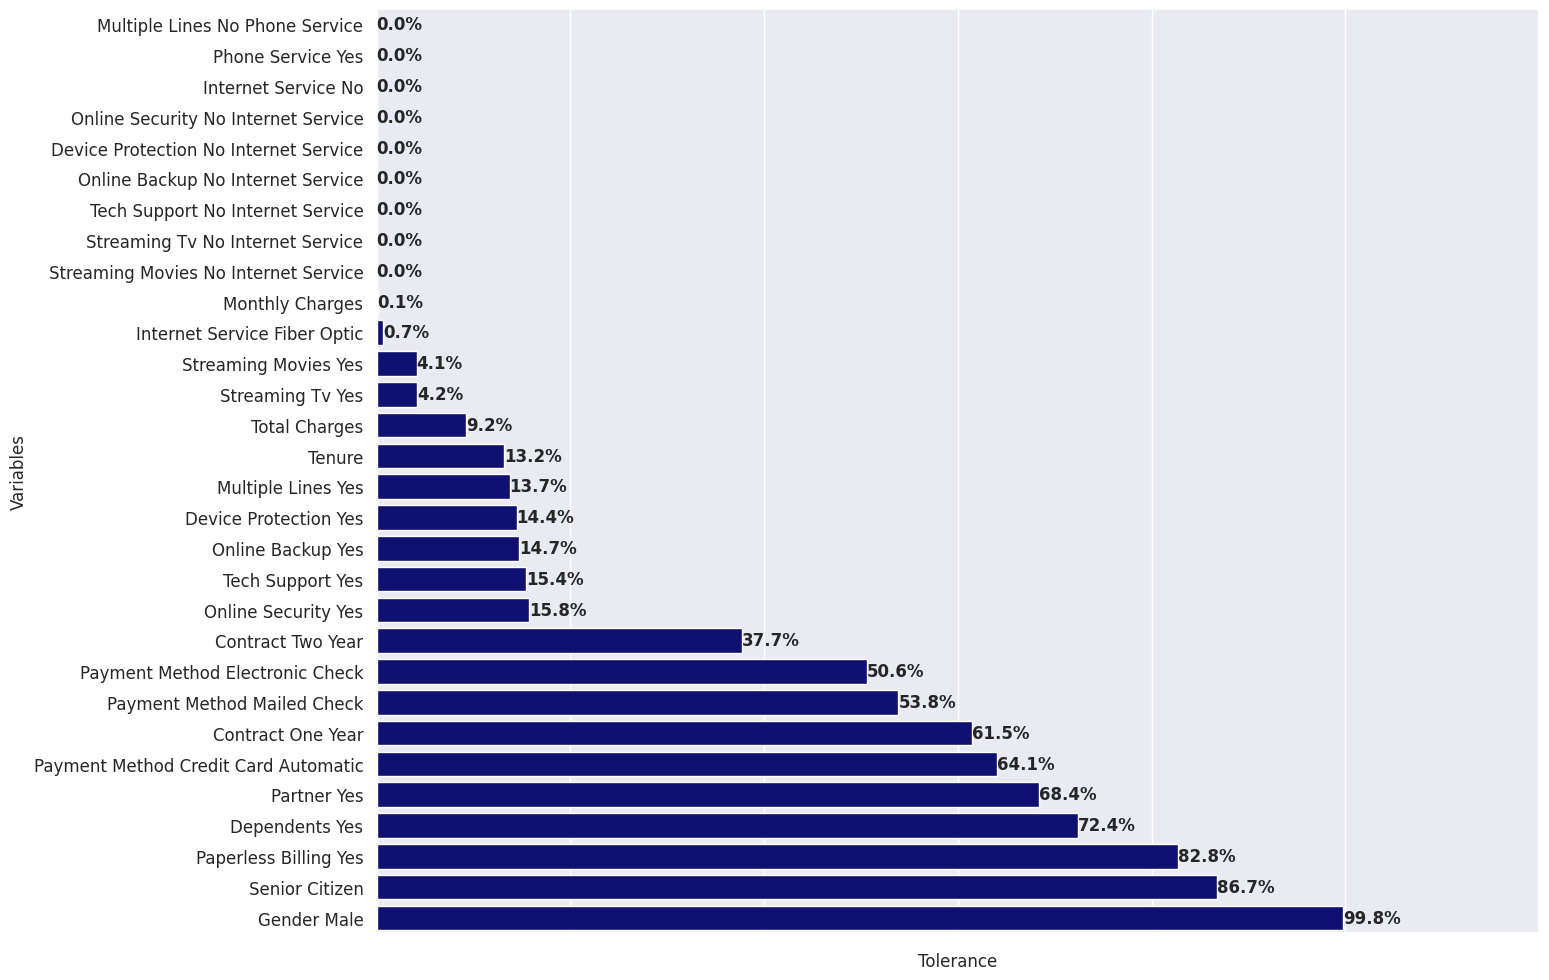

In [19]:
# Visualizing Tolerance
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,12))

ax = sns.barplot(
    data=df_vif_tolerance,
    y="variables",
    x="tolerance",
    color="navy",
    orient='h'
)

for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{p.get_width():.1%}",
        xy=(p.get_width(), i),
        fontsize=12,
        va="center",
        ha="left",
        weight="bold")

plt.xlabel("Tolerance")
plt.ylabel("Variables", fontsize=12)

plt.xticks(ticks=ax.get_xticks(), labels=[])
plt.yticks(
    ticks=ax.get_yticks(),
    labels=[label.get_text().replace("_", " ").title() for label in ax.get_yticklabels()],
    fontsize=12
    )

plt.show()

Variables with low tolerance values (or high VIF) are more likely to be dropped from the model due to multicollinearity in the stepwise procedure. However, it is necessary to manually drop variables showing perfect collinearity beforehand to avoid instability when estimating the coefficients and p-values.

In [20]:
# Removing perfectly collinear variables
corr_dict = df_telco_dummies.select_dtypes(exclude=object).corr().abs().to_dict()

drop_columns = []

for key_var, var_corr in corr_dict.items():
    for var, corr in var_corr.items():
        if corr == 1 and var not in drop_columns + [key_var]:
            drop_columns.append(key_var)
            break

df_telco_dummies.drop(columns=drop_columns, inplace=True)

print(drop_columns)

['internet_service_no', 'online_security_no_internet_service', 'online_backup_no_internet_service', 'device_protection_no_internet_service', 'tech_support_no_internet_service', 'streaming_tv_no_internet_service']


## Binary Logistic Regresion

Binary logistic regression is the most suitable model to predict churn behavior due to the nature of the outcome variable, which is qualitative and has only two categories: *YES* or *NO*.

<br>

Formulas:
> * Log-Odds Function:
> $$ \ln(\text{odds}) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n $$
>
> <br>
>
> * Probability Function:
> $$ P(y=1 | X) = \frac{1}{1 + e^{-z}} $$
>
> <br>
>
> where:
> >
> > $  \text{odds} = \Large \frac{P(y=1)}{1 - P(y=1)} $
> >
> >
> > <br>
> >
> > $ z = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n $



In [21]:
# Model Formula
formula = get_formula(df_telco_dummies, endog='churn', drop_columns=["customer_id"])
print(formula)

churn ~ senior_citizen + tenure + monthly_charges + total_charges + gender_male + partner_yes + dependents_yes + phone_service_yes + multiple_lines_no_phone_service + multiple_lines_yes + internet_service_fiber_optic + online_security_yes + online_backup_yes + device_protection_yes + tech_support_yes + streaming_tv_yes + streaming_movies_no_internet_service + streaming_movies_yes + contract_one_year + contract_two_year + paperless_billing_yes + payment_method_credit_card_automatic + payment_method_electronic_check + payment_method_mailed_check


In [22]:
# Logit model
logit_model = smf.logit(data=df_telco_dummies, formula=formula).fit()

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 12


In [23]:
# Model summary
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2845
Time:                        19:47:11   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.8340   2.34e+06   3.57e-07      1.000   -4.58e+06    4.58e+06
senior_citizen                           0.2168      0.085      2.564      0.010       0.051       0.382
tenure                                  -0.0606      0.006     -9.716      0.000      -0.073      -0.048
monthly_charges                         -0.0403      0.032     -1.270      0.204      -0.103       0.022
total_charges                            0.0003   7.06e-05      4.657      0.000       0.000       0.000
gender_male                             -0.0218      0.065     -0.337      0.736      -0.149       0.105
partner_yes                             -0.0004      0.078     -0.005      0.996      -0.153       0.152
dependents_yes                          -0.1485      0.090     -1.655      0.098      -0.324       0.027
phone_service_yes                        0.5027   2.34e+06   2.15e-07      1.000   -4.58e+06    4.58e+06
multiple_lines_no_phone_service          0.3313   2.34e+06   1.42e-07      1.000   -4.58e+06    4.58e+06
multiple_lines_yes                       0.4484      0.177      2.530      0.011       0.101       0.796
internet_service_fiber_optic             1.7475      0.798      2.190      0.029       0.183       3.312
online_security_yes                     -0.2054      0.179     -1.150      0.250      -0.556       0.145
online_backup_yes                        0.0260      0.175      0.148      0.882      -0.318       0.370
device_protection_yes                    0.1474      0.176      0.836      0.403      -0.198       0.493
tech_support_yes                        -0.1805      0.181     -0.999      0.318      -0.534       0.173
streaming_tv_yes                         0.5905      0.326      1.810      0.070      -0.049       1.230
streaming_movies_no_internet_service    -1.7863      0.807     -2.213      0.027      -3.369      -0.204
streaming_movies_yes                     0.5993      0.327      1.834      0.067      -0.041       1.240
contract_one_year                       -0.6608      0.108     -6.142      0.000      -0.872      -0.450
contract_two_year                       -1.3571      0.176     -7.691      0.000      -1.703      -1.011
paperless_billing_yes                    0.3424      0.074      4.596      0.000       0.196       0.488
payment_method_credit_card_automatic    -0.0878      0.114     -0.770      0.442      -0.311       0.136
payment_method_electronic_check          0.3045      0.094      3.222      0.001       0.119       0.490
payment_method_mailed_check             -0.0576      0.115     -0.501      0.616      -0.283       0.168
========================================================================================================
"""

Variables with p-values greater than 0.05 suggests they have little or no impact on the model and will be removed after the stepwise procedure. The loss of statistical significance may be caused by the low capacity of the predictor variable to explain the behavior of the outcome variable or by a high degree of association with other predictor variables, leading to redundancy (multicollinearity).

In [24]:
# Stepwise procedure
logit_model_sw = stepwise(logit_model)

Regression type: Logit 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('monthly_charges') + Q('total_charges') + Q('gender_male') + Q('partner_yes') + Q('dependents_yes') + Q('phone_service_yes') + Q('multiple_lines_no_phone_service') + Q('multiple_lines_yes') + Q('internet_service_fiber_optic') + Q('online_security_yes') + Q('online_backup_yes') + Q('device_protection_yes') + Q('tech_support_yes') + Q('streaming_tv_yes') + Q('streaming_movies_no_internet_service') + Q('streaming_movies_yes') + Q('contract_one_year') + Q('contract_two_year') + Q('paperless_billing_yes') + Q('payment_method_credit_card_automatic') + Q('payment_method_electronic_check') + Q('payment_method_mailed_check')
Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 12

 Discarding atribute "Q('multiple_lines_no_phone_service')" with p-value equal to 0.9999998869355059 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('month

In [25]:
# Model summary after stepwise
logit_model_sw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7016
Method:                           MLE   Df Model:                           15
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.2838
Time:                        19:47:12   Log-Likelihood:                -2916.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.8040      0.265      3.037      0.002       0.285       1.323
Q('senior_citizen')                           0.2437      0.083      2.941      0.003       0.081       0.406
Q('tenure')                                  -0.0610      0.006     -9.950      0.000      -0.073      -0.049
Q('monthly_charges')                         -0.0302      0.006     -5.223      0.000      -0.042      -0.019
Q('total_charges')                            0.0003      7e-05      4.787      0.000       0.000       0.000
Q('multiple_lines_yes')                       0.3930      0.088      4.490      0.000       0.221       0.565
Q('internet_service_fiber_optic')             1.4916      0.192      7.768      0.000       1.115       1.868
Q('online_security_yes')                     -0.2622      0.090     -2.927      0.003      -0.438      -0.087
Q('tech_support_yes')                        -0.2293      0.091     -2.513      0.012      -0.408      -0.050
Q('streaming_tv_yes')                         0.4973      0.098      5.094      0.000       0.306       0.689
Q('streaming_movies_no_internet_service')    -1.5618      0.177     -8.810      0.000      -1.909      -1.214
Q('streaming_movies_yes')                     0.5112      0.096      5.298      0.000       0.322       0.700
Q('contract_one_year')                       -0.6638      0.107     -6.198      0.000      -0.874      -0.454
Q('contract_two_year')                       -1.3600      0.176     -7.738      0.000      -1.704      -1.016
Q('paperless_billing_yes')                    0.3440      0.074      4.632      0.000       0.198       0.490
Q('payment_method_electronic_check')          0.3528      0.069      5.098      0.000       0.217       0.488
=============================================================================================================
"""

In [26]:
# Calculating churn probability
df_telco_dummies[["customer_id", "churn"]].assign(
    prob=logit_model_sw.predict()
).sort_values("prob", ascending=False)

,customer_id,churn,prob
1976,9497-QCMMS,1,0.856110
4800,9300-AGZNL,1,0.854447
3749,4424-TKOPW,1,0.851685
1410,7024-OHCCK,1,0.850585
6368,2720-WGKHP,1,0.850472
...,...,...,...
5018,6928-ONTRW,0,0.001302
1527,0640-YJTPY,0,0.001301
1824,0794-YVSGE,0,0.001288
932,5787-KXGIY,0,0.001285


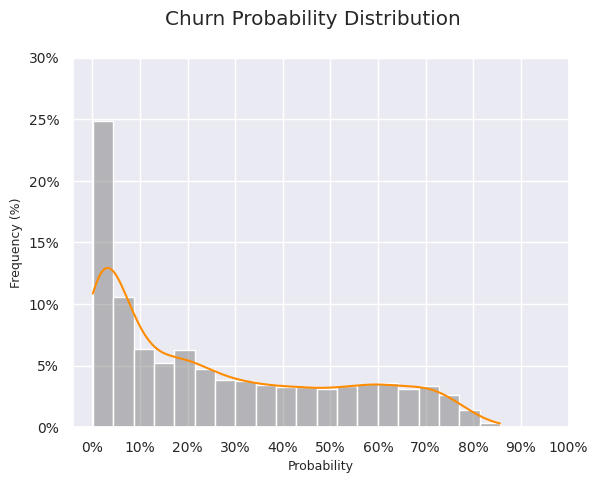

In [27]:
# Visualizing churn probability distribution
xticks = np.linspace(0, 1, 11)
xlabels = [f"{x:.0%}" for x in np.linspace(0, 1, 11)]

ax = sns.histplot(
    logit_model_sw.predict(),
    kde=True,
    stat="proportion",
    color="grey",
)

ax.lines[0].set_color("darkorange")
ax.set_yticks(
    ticks = ax.get_yticks(),
    labels = [f"{x:.0%}" for x in ax.get_yticks()],
    fontsize = 10
)
ax.set_xticks(
    ticks = xticks,
    labels = xlabels,
    fontsize = 10
)

plt.ylabel(None)
plt.xlabel("Probability", fontsize=9)
plt.ylabel("Frequency (%)", fontsize=9)
plt.suptitle("Churn Probability Distribution")

plt.show()

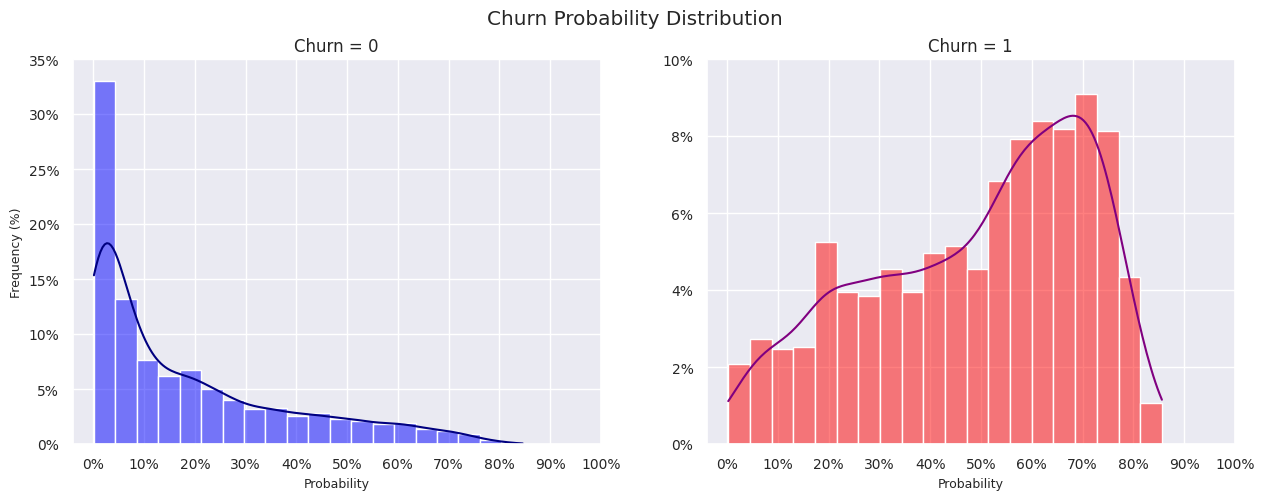

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df_churn_probs = df_telco_dummies[["churn"]].assign(prob=logit_model_sw.predict())

xticks = np.linspace(0, 1, 11)
xlabels = [f"{x:.0%}" for x in np.linspace(0, 1, 11)]

sns.histplot(
    data = df_churn_probs.loc[df_churn_probs.churn==0],
    x = "prob",
    bins = 20,
    kde = True,
    stat = "proportion",
    color = 'blue',
    ax = axes[0]
)

axes[0].lines[0].set_color("navy")
axes[0].set_title("Churn = 0")
axes[0].set_xticks(
    ticks = xticks,
    labels = xlabels,
    fontsize = 10
    )
axes[0].set_yticks(
    ticks = axes[0].get_yticks(),
    labels = [f"{x:.0%}" for x in axes[0].get_yticks()],
    fontsize = 10
    )
axes[0].set_ylabel("Frequency (%)", fontsize=9)
axes[0].set_xlabel("Probability", fontsize=9)

sns.histplot(
    data = df_churn_probs.loc[df_churn_probs.churn==1],
    x = "prob",
    bins = 20,
    kde = True,
    stat = "proportion",
    color ="red",
    ax = axes[1],
)

axes[1].lines[0].set_color("purple")
axes[1].set_title("Churn = 1")
axes[1].set_xticks(
    ticks = xticks,
    labels = xlabels,
    fontsize = 10
    )
axes[1].set_yticks(
    ticks = axes[1].get_yticks(),
    labels = [f"{x:.0%}" for x in axes[1].get_yticks()],
    fontsize = 10
    )
axes[1].set_ylabel("", fontsize=9)
axes[1].set_xlabel("Probability", fontsize=9)

plt.suptitle("Churn Probability Distribution")
plt.show()

## Model Metrics

The confusion matrix evaluates the performance of classification models by applying a cutoff (threshold) to convert predicted probabilities into class labels.

Probabilities above the cutoff are classified as *YES* for churn in this context.

<br>

Formulas:
>
> $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
>
> <br>
>
> $$ \text{Sensitivity} = \frac{TP}{TP + FN} $$
>
> <br>
>
> $$ \text{Specificity} = \frac{TN}{TN + FP} $$
>
> <br>
>
> where:
>
>> **TP (True Positive):** The number of positive cases correctly predicted as positive.
>>
>> **TN (True Negative):** The number of negative cases correctly predicted as negative.
>>
>> **FP (False Positive):** The number of negative cases incorrectly predicted as positive.
>>
>> **FN (False Negative):** The number of positive cases incorrectly predicted as negative.


{'Accuracy': 0.8053185437997725,
 'Sensitivity': 0.5537720706260032,
 'Specificity': 0.8963780747627348}

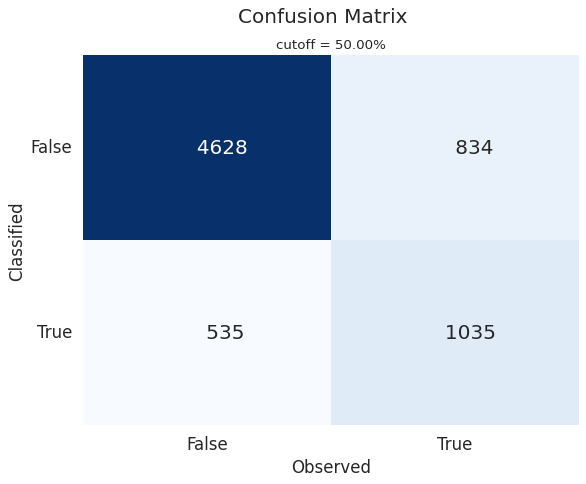

In [29]:
confusion_matrix(logit_model_sw, cutoff=0.5)

In [30]:
df_metrics = confusion_metrics(logit_model_sw)
df_metrics

,cutoff,accuracy,sensitivity,specificity
0,0.01,0.360922,0.996255,0.130932
1,0.02,0.425341,0.991439,0.220414
2,0.03,0.461746,0.986089,0.271935
3,0.04,0.493174,0.983414,0.315708
4,0.05,0.520620,0.976458,0.355607
...,...,...,...,...
95,0.96,0.734215,0.000000,1.000000
96,0.97,0.734215,0.000000,1.000000
97,0.98,0.734215,0.000000,1.000000
98,0.99,0.734215,0.000000,1.000000


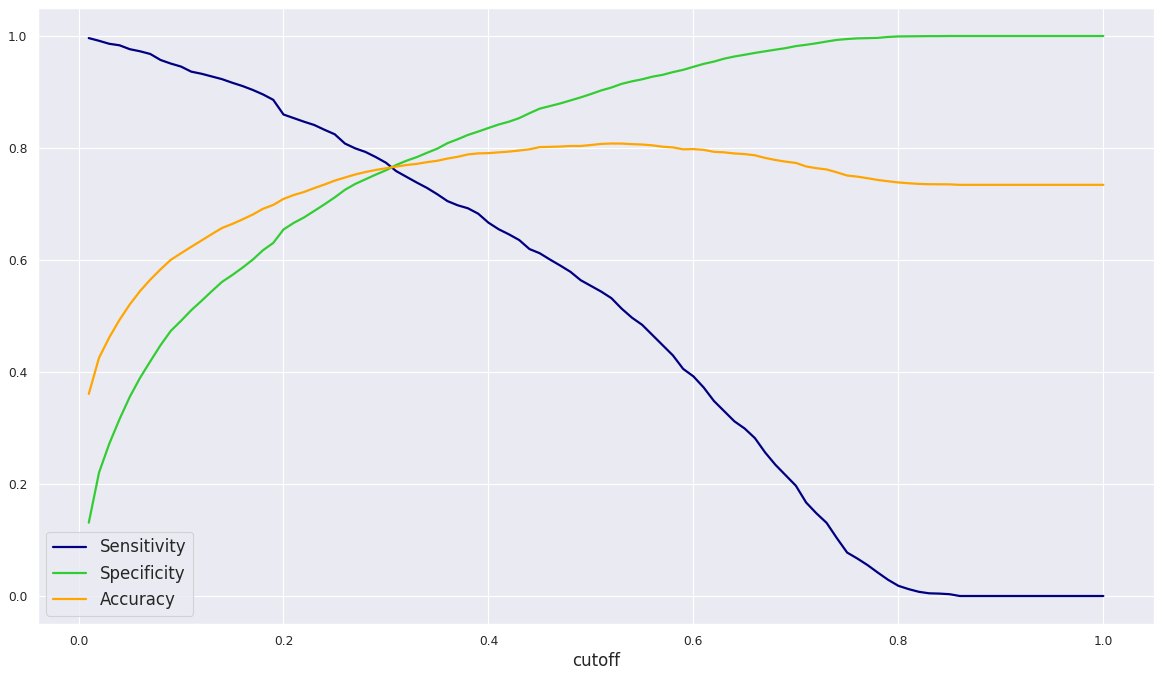

In [31]:
# Visualizing the relationship between sensitivity, specificity, and accuracy across different cutoff values
plt.figure(figsize=(18,10), dpi=80)

plt.plot(
    df_metrics.cutoff,
    df_metrics.sensitivity,
    color="navy",
    lw=2,
    label="Sensitivity"
)

plt.plot(
    df_metrics.cutoff,
    df_metrics.specificity,
    color='limegreen',
    lw=2,
    label="Specificity"
)

plt.plot(
    df_metrics.cutoff,
    df_metrics.accuracy,
    color="orange",
    lw=2,
    label="Accuracy"
)

plt.xlabel("cutoff", fontsize=15)

plt.legend(fontsize=15)
plt.show()

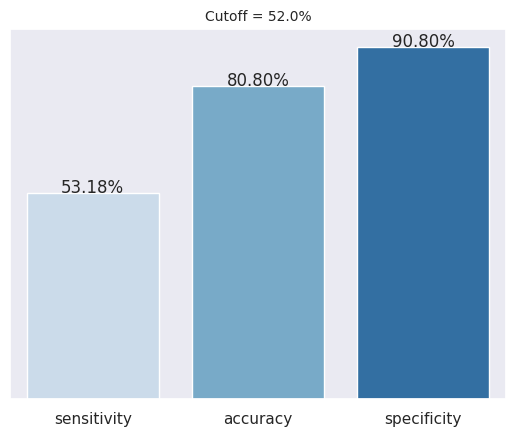

In [32]:
# Maximizing accuracy
df_max_accuracy = df_metrics.loc[df_metrics['accuracy'].idxmax()].sort_values()

cutoff = df_max_accuracy.cutoff

max_accuracy_metrics = df_max_accuracy.drop("cutoff").to_dict()

ax = sns.barplot(
    x = max_accuracy_metrics.keys(),
    y = max_accuracy_metrics.values(),
    hue = max_accuracy_metrics.keys(),
    palette="Blues"
)

for i, p in enumerate(ax.patches):
    plt.annotate(f"{p.get_height():.2%}", xy=(i, p.get_height()), ha="center")

plt.yticks([])
plt.ylabel(None)
plt.title(f"Cutoff = {cutoff:.1%}", fontsize=10)

plt.show()

The ROC curve (Receiver Operating Characteristic) is a graphical tool used to evaluate the performance of binary classification models. It shows the relationship between the False Positive Rate (FPR) and the True Positive Rate (TPR), for different cutoff (decision threshold) values.

<br>

Formulas:
> $$ \text{Gini Coefficient} = \frac{(\text{AURC} - 0.5)}{0.5} $$
>
> <br>
>
> where:
> > AURC: Area under the ROC curve

In [33]:
# Calculating ROC Curve and its Axes (FPR x TPR)
fpr, tpr, thresholds = roc_curve(
    y_true=logit_model_sw.model.endog,
    y_score=logit_model_sw.predict()
)

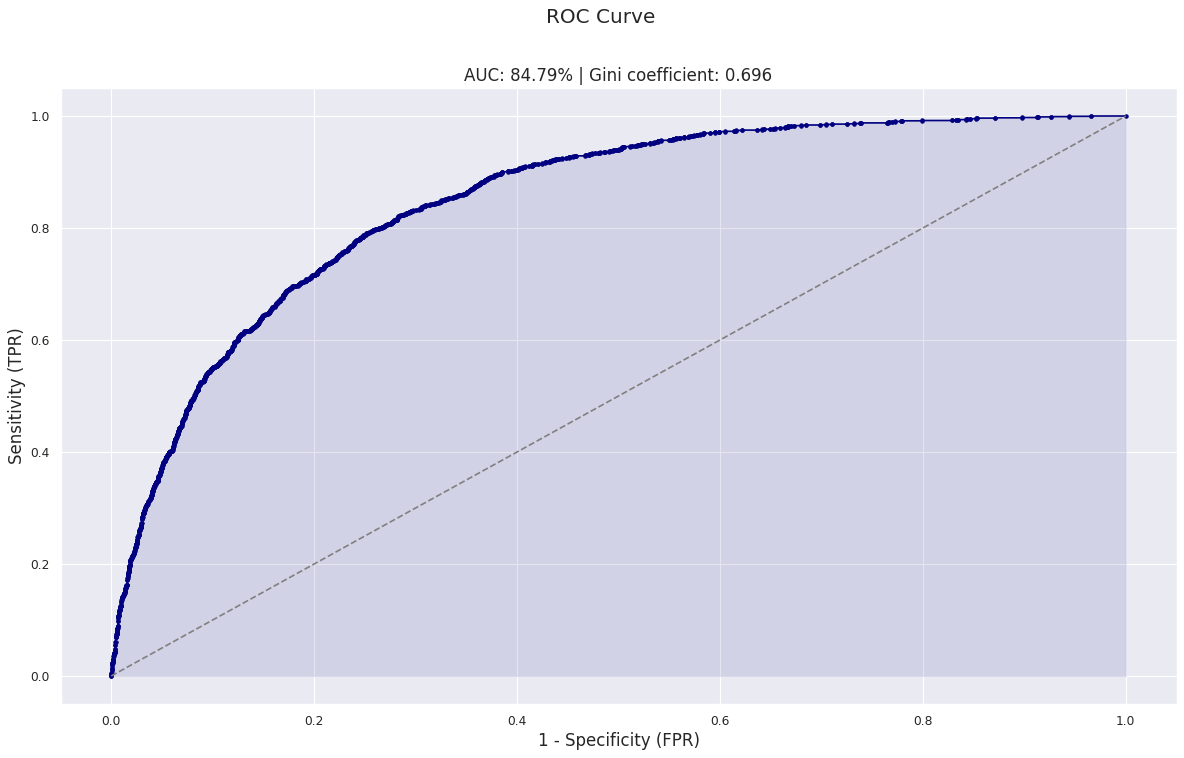

In [34]:
roc_auc = auc(x=fpr, y=tpr)
gini = (roc_auc - 0.5) / 0.5

plt.figure(figsize=(18,10), dpi=80)

plt.plot(
    fpr,
    tpr,
    color="navy",
    marker="."
)

plt.fill_between(
    fpr,
    tpr,
    color="navy",
    alpha=0.1
)

plt.plot(
    [0,1],
    [0,1],
    ls = "--",
    color="grey"
)

plt.xlabel("1 - Specificity (FPR)", fontsize=15)
plt.ylabel("Sensitivity (TPR)", fontsize=15)

plt.title(f"AUC: {roc_auc:.2%} | Gini coefficient: {gini:.3f}", fontsize=15)
plt.suptitle("ROC Curve", fontsize=18)

plt.show()

The Area Under the Curve (AUC) is a common performance measure, where values closer to 1 indicate better model performance. An AUC of 0.5 indicates random performance, while values greater than 0.5 show that the model has some discriminatory ability. To improve the model and increase the AUC, it is crucial to identify and include additional predictor variables that pass the significance test in the stepwise procedure.